# Image Posterization using K-means Clustering Algorithm

In [9]:
#import PIL as pil
from PIL import Image
from skimage import io
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import joblib
import time
import os 


In [13]:
def smartPost(oldImage, percentage, fileName, elbowPoint, minK, *args, **kwargs):
    image = oldImage
    pixels = image.load()
    fileNameOverride = ""
    fileNameOverride = kwargs.get('fileNameOverride', None)

    random.seed(a=100)
    #k = 100   #we would have a loop and iterate k

    skip = int(1 / np.sqrt(percentage))
    count = 0
    size = np.ceil(image.size[0] / skip) * np.ceil(image.size[1] / skip)
    df_pixels = pd.DataFrame(columns=list('RGB'), index = np.arange(size))

    timeBeforeSample = time.time()
    for i in range(0, image.size[0], skip):
        for j in range(0, image.size[1], skip):
            i_ = i + random.randint(-3,3)
            if i_>=image.size[0]:
                i_ = image.size[0] - 1
            if i_<0:
                i_ = 0
            j_ = j + random.randint(-3,3)
            if j_>=image.size[1]:
                j_ = image.size[1] - 1
            if j_<0:
                j_ = 0
                
            df_pixels.iloc[[count]] = [[pixels[i_,j_][0], pixels[i_,j_][1], pixels[i_,j_][2]]]
            count = count + 1
    timeAfterSample = time.time()
    sampleTime = timeAfterSample - timeBeforeSample
    distortions = []
    for k in range(minK,150):
        kmeans = KMeans(n_clusters=k, random_state=1, n_init=1) #k
        kmeans.fit(df_pixels) #run on df_pixels
        if k >=2:
            if kmeans.inertia_ / lastIntertia > elbowPoint:     ####### 0.98 is the location on the elbow we select for the ideal k
                    break
            if kmeans.inertia < 100000:
                break
        lastIntertia = kmeans.inertia_
        distortions.append(lastIntertia)
    
    
    timeAfterKmeansFit = time.time()

    KMeansTime = timeAfterKmeansFit - timeAfterSample

    joblib.dump(kmeans, 'kmeans.pkl')
    kmeans_loaded = joblib.load('kmeans.pkl')
    kmeans_loaded

    timeAfterPickle = time.time()
    PickleTime = timeAfterPickle - timeAfterKmeansFit



    for i in range(0, image.size[0]):
        for j in range(0, image.size[1]):
            predicted = kmeans_loaded.predict([[pixels[i,j][0], pixels[i,j][1], pixels[i,j][2]]])
            pixels[i,j] = (round(kmeans.cluster_centers_[predicted][0][0]), round(kmeans.cluster_centers_[predicted][0][1]), round(kmeans.cluster_centers_[predicted][0][2]))
            #pixels[i,j] = (0,0,0)

    timeAfterCompression = time.time()
    CompressionTime = timeAfterCompression - timeAfterPickle

    saveLocation = fileName.replace("Inputs","Outputs")
    saveLocation = saveLocation + fileNameOverride

    image.save(saveLocation, format="png")

    timeAfterSave = time.time()
    SaveTime = timeAfterSave - timeAfterCompression
    return distortions, k

In [14]:
def findBestK(oldImage, percentage, fileName, elbowPoint):
    image = oldImage
    pixels = image.load()

    random.seed(a=100)
    #k = 100   #we would have a loop and iterate k

    skip = int(1 / np.sqrt(percentage))
    count = 0
    size = np.ceil(image.size[0] / skip) * np.ceil(image.size[1] / skip)
    df_pixels = pd.DataFrame(columns=list('RGB'), index = np.arange(size))
    if percentage != 1:
        for i in range(0, image.size[0], skip):
            for j in range(0, image.size[1], skip):
                i_ = i + random.randint(-3,3)
                if i_>=image.size[0]:
                    i_ = image.size[0] - 1
                if i_<0:
                    i_ = 0
                j_ = j + random.randint(-3,3)
                if j_>=image.size[1]:
                    j_ = image.size[1] - 1
                if j_<0:
                    j_ = 0
                    
                df_pixels.iloc[[count]] = [[pixels[i_,j_][0], pixels[i_,j_][1], pixels[i_,j_][2]]]
                count = count + 1
    else:
        for i in range(0, image.size[0], skip):
            for j in range(0, image.size[1], skip):
                df_pixels.iloc[[count]] = [[pixels[i,j][0], pixels[i,j][1], pixels[i,j][2]]]
                count = count + 1
    distortions = []
    for k in range(1,150):
        kmeans = KMeans(n_clusters=k, random_state=1, n_init=1) #k
        kmeans.fit(df_pixels) #run on df_pixels
        if k >=2:
            if kmeans.inertia_ / lastIntertia > elbowPoint:     ####### 0.98 is the location on the elbow we select for the ideal k
                  break
        lastIntertia = kmeans.inertia_
        distortions.append(lastIntertia)
    
    
    return distortions, k

AttributeError: 'KMeans' object has no attribute 'inertia'

lowPercentageK=76

highPercentageK=111



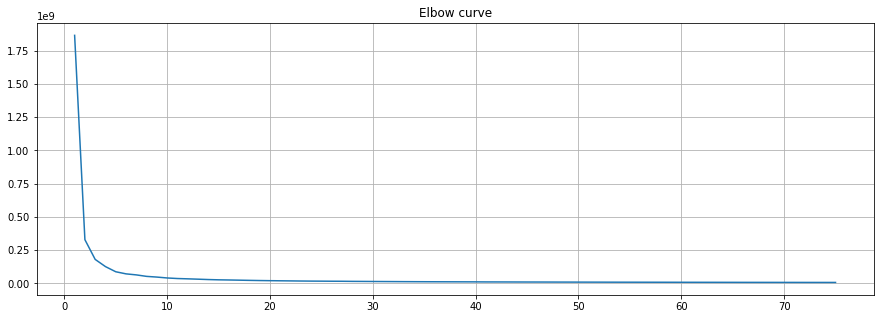

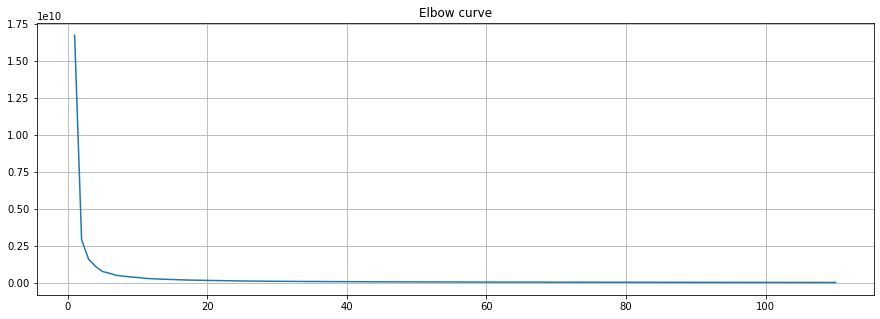

In [11]:
percentage = 0.10
lowPercentageK = 0
highPercentageK = 0

currDir = 'Inputs/Explorations' 
for filename in os.listdir(currDir):
   if filename.endswith(".png"):
        currImg = Image.open(str(currDir)+'/'+str(filename))
        distortions, lowPercentageK = findBestK(currImg, percentage, str(currDir)+'/'+str(filename), 0.995)
        fig1 = plt.figure(figsize=(15, 5))
        plt.plot(range(1, lowPercentageK), distortions)
        plt.grid(True)
        fig1 = plt.title('Elbow curve')
print("lowPercentageK={0}\n".format(lowPercentageK))

percentage = 1

for filename in os.listdir(currDir):
   if filename.endswith(".png"):
        currImg = Image.open(str(currDir)+'/'+str(filename))
        distortions, highPercentageK = findBestK(currImg, percentage, str(currDir)+'/'+str(filename), 0.995)
        fig1 = plt.figure(figsize=(15, 5))
        plt.plot(range(1, highPercentageK), distortions)
        plt.grid(True)
        fig1 = plt.title('Elbow curve')
print("highPercentageK={0}\n".format(highPercentageK))

1 min 10 seconds to find lowPercentageK

In [12]:
percentage = 0.10

k=78.0



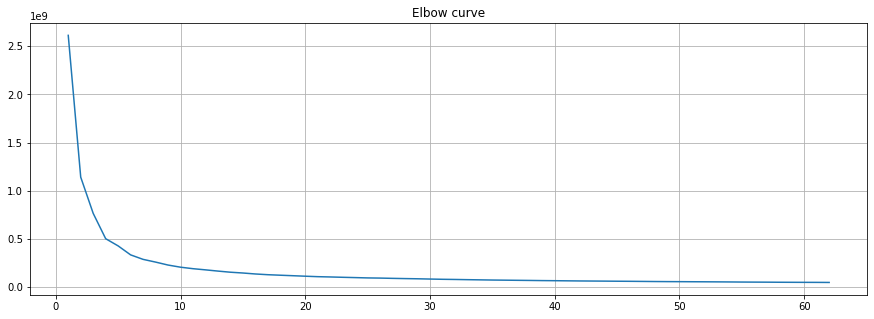

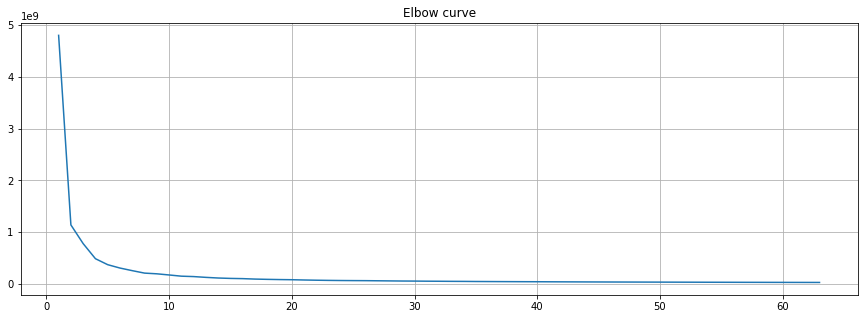

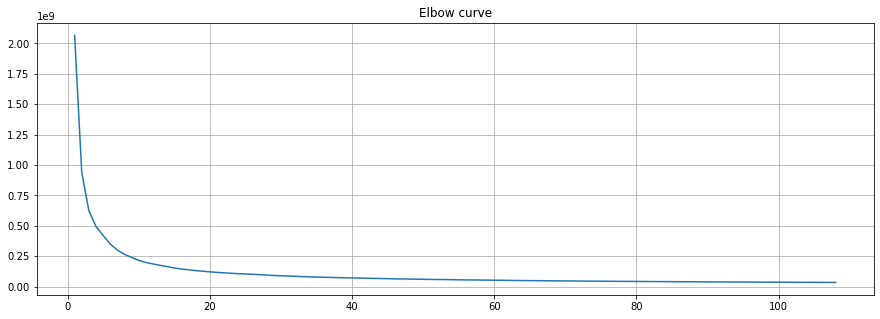

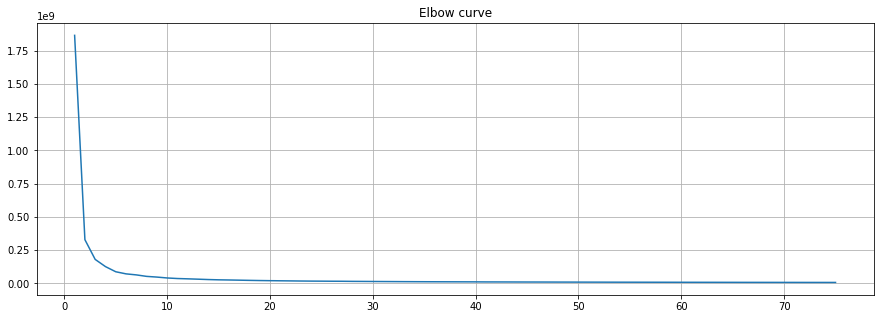

In [13]:
currDir = 'Inputs/Landscapes' 
kAvgLandscapes = 0
landscapeCount = 0
for filename in os.listdir(currDir):
   if filename.endswith(".png"):
        currImg = Image.open(str(currDir)+'/'+str(filename))
        distortions, k = smartPost(currImg, percentage, str(currDir)+'/'+str(filename), 0.995, 1)
        landscapeCount = landscapeCount+1
        kAvgLandscapes = kAvgLandscapes+k
        fig1 = plt.figure(figsize=(15, 5))
        plt.plot(range(1, k), distortions)
        plt.grid(True)
        fig1 = plt.title('Elbow curve')
kAvgLandscapes = kAvgLandscapes / landscapeCount
print("k={0}\n".format(kAvgLandscapes))

k=100.33333333333333



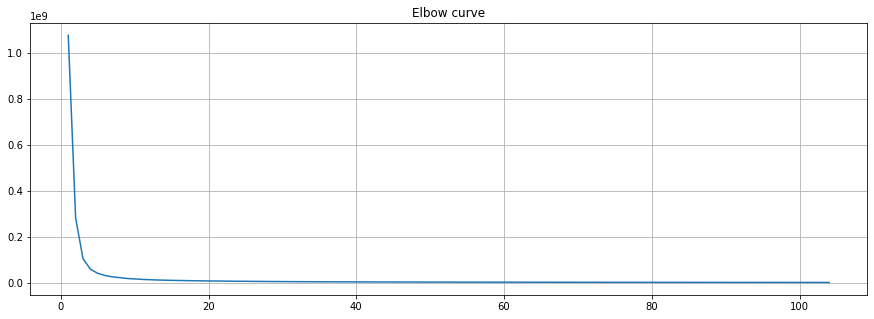

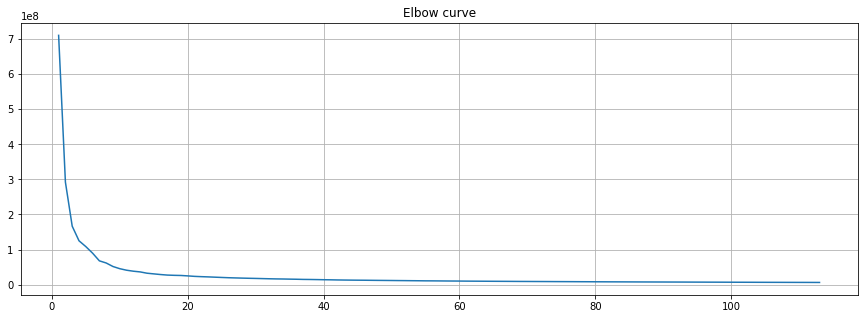

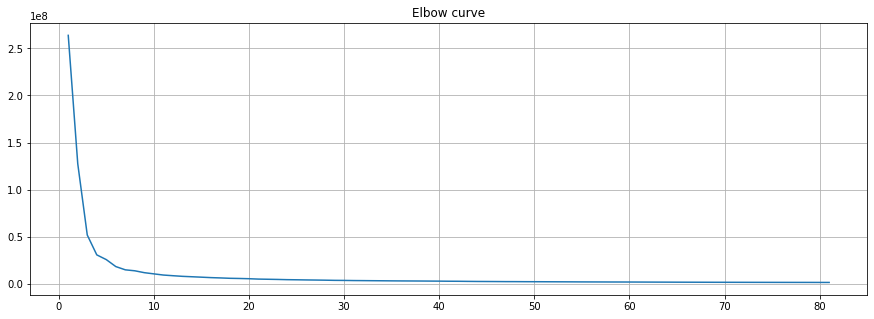

In [14]:
currDir = 'Inputs/Animals' 
kAvgAnimals = 0
animalCount = 0
for filename in os.listdir(currDir):
    if filename.endswith(".png"):
        currImg = Image.open(str(currDir)+'/'+str(filename))
        distortions, k = smartPost(currImg, percentage, str(currDir)+'/'+str(filename), 0.995, 1)
        animalCount = animalCount+1
        kAvgAnimals = kAvgAnimals+k
        fig2 = plt.figure(figsize=(15, 5))
        plt.plot(range(1, k), distortions)
        plt.grid(True)
        fig2 = plt.title('Elbow curve')
kAvgAnimals = kAvgAnimals/animalCount
print("k={0}\n".format(kAvgAnimals))

k=84.5



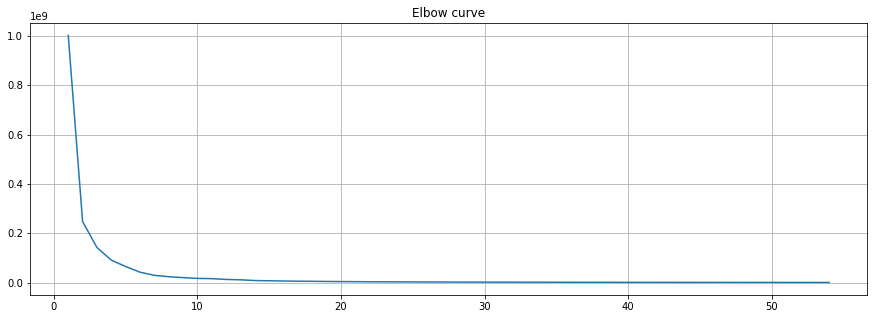

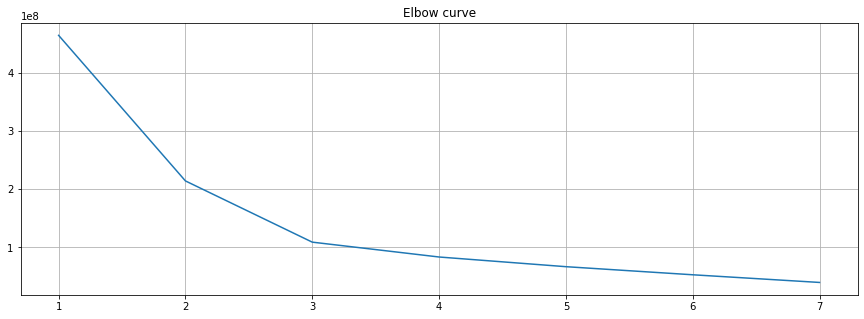

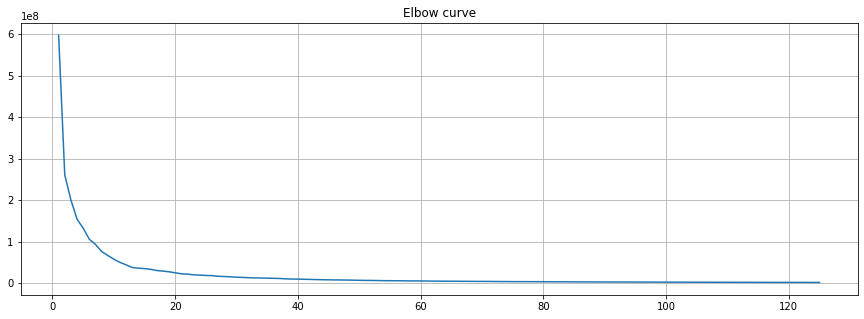

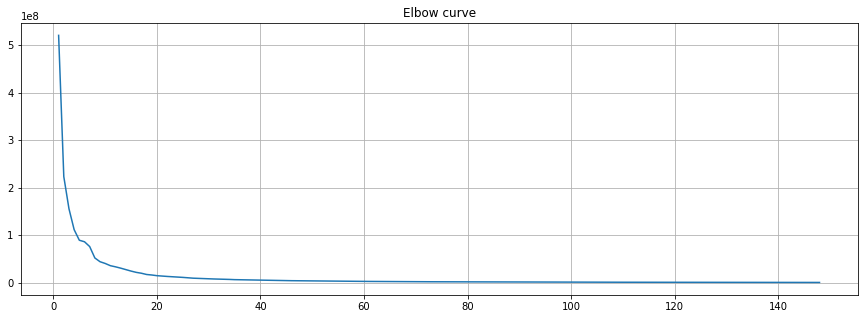

In [15]:
currDir = 'Inputs/Gradients' 
kAvgGradients = 0
gradientCount = 0
for filename in os.listdir(currDir):
    if filename.endswith(".png"):
        currImg = Image.open(str(currDir)+'/'+str(filename))
        distortions, k = smartPost(currImg, percentage, str(currDir)+'/'+str(filename), 0.995, 1)
        gradientCount = gradientCount+1
        kAvgGradients = kAvgGradients+k
        fig3 = plt.figure(figsize=(15, 5))
        plt.plot(range(1, k), distortions)
        plt.grid(True)
        fig3 = plt.title('Elbow curve')
        
kAvgGradients = kAvgGradients/gradientCount
print("k={0}\n".format(kAvgGradients))

k=88.75



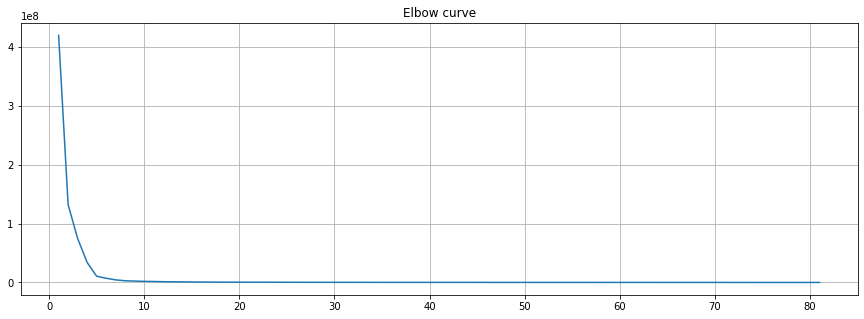

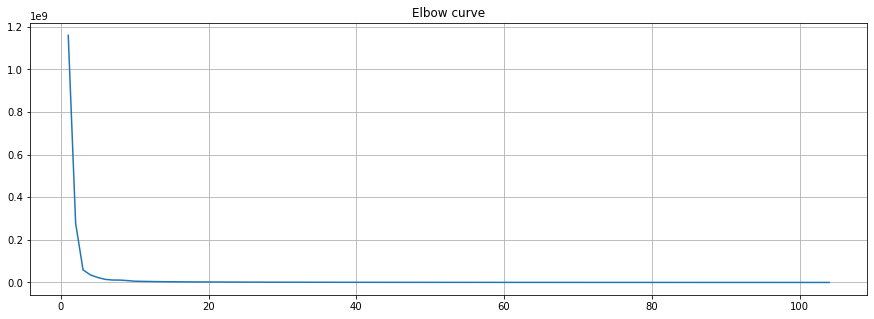

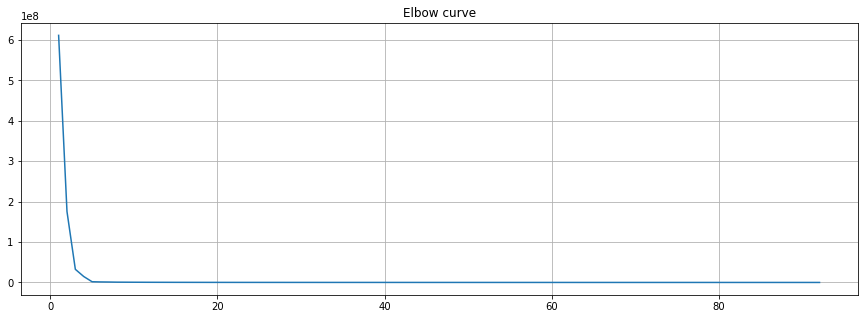

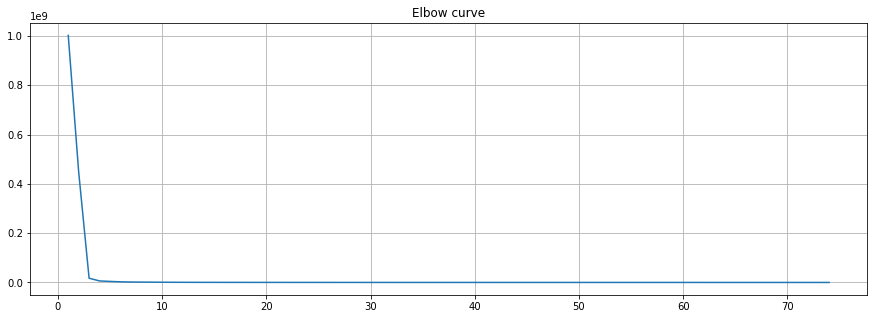

In [31]:
currDir = 'Inputs/Simple' 
kAvgSimple = 0
simpleCount = 0
for filename in os.listdir(currDir):
    if filename.endswith(".png"):
        currImg = Image.open(str(currDir)+'/'+str(filename))
        distorions = []
        distortions, k = smartPost(currImg, percentage, str(currDir)+'/'+str(filename), 0.995, 1)
        simpleCount = simpleCount+1
        kAvgSimple = kAvgSimple+k
        fig3 = plt.figure(figsize=(15, 5))
        plt.plot(range(1, k), distortions)
        plt.grid(True)
        fig3 = plt.title('Elbow curve')
        currImg.close()
kAvgSimple = kAvgSimple/simpleCount
print("k={0}\n".format(kAvgSimple))

In [32]:
print("kAvgAnimals, kAvgLandscapes, kAvgGradients, kAvgSimple = {0}, {1}, {2}, {3}\n".format(kAvgAnimals, kAvgLandscapes, kAvgGradients, kAvgSimple))

kAvgAnimals, kAvgLandscapes, kAvgGradients, kAvgSimple = 100.33333333333333, 78.0, 84.5, 88.75

